In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [4]:
%cd C:\\Users\\Yurt\\Documents\\Cambridge\\GNN\\gnn_explainability

C:\Users\Yurt\Documents\Cambridge\GNN\gnn_explainability


In [49]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [6]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [8]:
epochs = 3000
dim = 20

## GCExplainer

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [10]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.186315 Train_acc: 0.9750, Test_acc: 0.9071]: 100%|███████████████████| 3000/3000 [00:58<00:00, 51.03it/s]


In [11]:
gce_explainer = GCExplainer()

In [12]:
gce_explainer.learn_prototypes(model,ba_dataset)

C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [13]:
gce_explainer.get_prediction(model,ba_dataset)

array([3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 3, 0,
       3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 3, 2, 0, 3, 1, 1, 1,
       3, 1, 3, 3, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1,
       3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 0, 3, 2, 2, 0, 1, 3, 1, 3, 1, 3, 3,
       1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3,
       1, 1, 1, 1, 1, 3, 0, 2], dtype=int64)

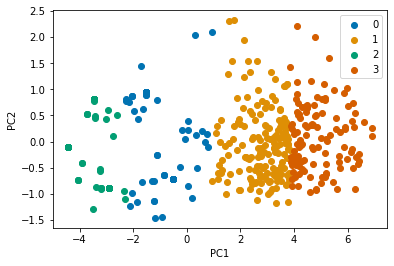

In [14]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [15]:
gce_explainer.get_prediction(model,identity(ba_dataset))

array([3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 3, 0,
       3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 3, 2, 0, 3, 1, 1, 1,
       3, 1, 3, 3, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1,
       3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 0, 3, 2, 2, 0, 1, 3, 1, 3, 1, 3, 3,
       1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3,
       1, 1, 1, 1, 1, 3, 0, 2], dtype=int64)

In [16]:
gce_explainer.get_completeness(model,identity(ba_dataset))

0.8714285714285714

## ProtGNN

In [55]:
model = GCNNet_NC(num_features, num_classes, model_args).to(device)

20


In [18]:
model.load_state_dict(torch.load("../models/protgnn_bashapes.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '../models/protgnn_bashapes.pt'

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [42]:
model = train_model(300,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:0.758035 Train_acc: 0.6393, Test_acc: 0.5571]: 100%|█████████████████████| 300/300 [00:19<00:00, 15.44it/s]


In [54]:
prot_explainer = ProtGNNExplainer()

In [51]:
prot_explainer.learn_prototypes(model,ba_dataset)

Parameter containing:
tensor([[ 4.5152e-02,  8.3712e-03,  2.4114e-01,  ...,  3.1308e-01,
          2.3096e-01,  7.8146e-02],
        [ 3.0119e-02,  2.5905e-02, -3.3321e-03,  ..., -9.8008e-03,
         -1.2251e-03, -7.8927e-04],
        [ 7.3347e-03,  6.8882e-02,  2.5487e-03,  ..., -1.0199e-02,
          3.4759e-02,  6.9877e-02],
        ...,
        [ 2.8897e-03,  1.0690e-02,  3.2472e-02,  ...,  3.3235e-02,
         -3.0388e-03,  1.9525e-03],
        [ 1.1636e-02, -6.9539e-08, -7.5830e-03,  ..., -9.8608e-03,
          5.5682e-02, -5.7599e-03],
        [ 2.3782e-03,  4.8228e-08, -6.4975e-03,  ...,  3.9509e-03,
         -4.8631e-03, -5.5258e-03]], requires_grad=True)


In [52]:
prot_explainer.get_prediction(model,ba_dataset)

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  0, 14, 14, 14, 14,
       14,  9,  0, 14, 14, 14, 14, 14, 14, 14,  9, 14, 14, 14, 14,  9, 14,
       14, 14,  9, 14, 14, 14,  9, 14, 14,  9, 14, 14, 14,  9,  9, 14, 14,
        9, 14, 14, 14,  9, 14, 14, 14,  9, 14, 14, 14, 14,  9, 14, 14,  9,
       14, 14,  9, 14, 14,  9, 14, 14, 14, 14, 14,  9, 14, 14, 14, 14, 14,
       14,  9, 14, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14, 14,
        9, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14,
        0, 14, 14, 14, 14,  9,  9, 14, 14,  9, 14, 14,  9, 14, 14, 14, 14,
       14,  9, 14, 14, 14, 14, 14,  9,  9, 14, 14,  9, 14, 14, 14, 14, 14,
       14,  9, 14, 14,  9, 14, 14, 14, 14, 14,  9, 14, 14,  9,  9, 14, 14,
       14,  9, 14,  9, 14,  9, 14, 14, 14, 14,  0,  9, 14, 14, 14, 14,  0,
       14, 14,  9, 14, 14, 14,  9, 14, 14,  9, 14, 14,  9, 14, 14,  9,  0,
       14, 14,  9,  9, 14

In [53]:
probs = prot_explainer.get_prototype_probs(model,ba_dataset)
print(probs.shape)

(700, 20)


## CDM

In [24]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [26]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:5.272282 Train_acc: 0.9804, Test_acc: 0.9143]: 100%|███████████████████| 3000/3000 [01:34<00:00, 31.58it/s]


In [27]:
cdm_explainer = CDMExplainer()

In [28]:
cdm_explainer.learn_prototypes(model, ba_dataset)

In [29]:
cdm_explainer.get_prediction(model, ba_dataset)

Explanation class 0: ~feature0000000003 - acc. = 0.9214 - compl. = 1.0000
Explanation class 1: ~feature0000000000 & ~feature0000000003 & ~feature0000000006 & ~feature0000000016 - acc. = 0.9571 - compl. = 4.0000
Explanation class 2: feature0000000004 - acc. = 0.9357 - compl. = 1.0000
Explanation class 3: feature0000000000 - acc. = 0.8786 - compl. = 1.0000


{'0': {'explanation': '~feature0000000003',
  'explanation_accuracy': 0.9214285714285714,
  'explanation_complexity': 1},
 '1': {'explanation': '~feature0000000000 & ~feature0000000003 & ~feature0000000006 & ~feature0000000016',
  'explanation_accuracy': 0.9571428571428572,
  'explanation_complexity': 4},
 '2': {'explanation': 'feature0000000004',
  'explanation_accuracy': 0.9357142857142857,
  'explanation_complexity': 1},
 '3': {'explanation': 'feature0000000000',
  'explanation_accuracy': 0.8785714285714286,
  'explanation_complexity': 1}}

In [30]:
cdm_explainer.get_completeness(model, ba_dataset)

0.6318986987631138

In [31]:
cdm_explainer.get_concepts(model, ba_dataset)

tensor([[0.6199, 0.5400, 0.9972,  ..., 0.3578, 0.9577, 0.9885],
        [0.6199, 0.5400, 0.9972,  ..., 0.3578, 0.9577, 0.9885],
        [0.6199, 0.5400, 0.9972,  ..., 0.3578, 0.9577, 0.9885],
        ...,
        [0.0818, 0.0361, 0.2505,  ..., 0.0326, 0.2403, 0.2500],
        [0.7876, 0.1046, 0.1350,  ..., 0.1945, 0.2421, 0.2558],
        [1.0000, 0.9386, 0.5941,  ..., 0.9497, 0.6448, 0.6648]],
       grad_fn=<DivBackward0>)

## Adversary Methods

In [32]:
ba_aggressive = aggressive_adversary(ba_dataset,0.1)

In [33]:
ba_aggressive.edge_index.int()

tensor([[ 44,  49,  53,  ..., 302, 518,  36],
        [  0,   1,   2,  ..., 279, 279, 279]], dtype=torch.int32)

In [34]:
ba_conservative = conservative_adversary(ba_dataset, 'BAShapes', 0.1)

UnboundLocalError: local variable 'vertices' referenced before assignment

In [ ]:
ba_conservative.edge_index.int()

## Plot Prelim Results

In [ ]:
plot_metric('results', 'bashapes', 'fidelity_plus')
plot_metric('results', 'bashapes', 'completeness')
plot_difference_metric('results/concepts', 'bashapes', 'concepts')